In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Initialize(particle_per_cell, node_num, domain_height, dt, simulation_time,randomParticle):
    if randomParticle:
        particle_num = (node_num - 1) * (particle_per_cell)   # Number of particles in 'x' dimension # 1D
        dx = domain_height / (node_num - 1)  # Node spacing
        dp = domain_height / (particle_num - 1)  # Particle spacing
        xI = np.arange(0, domain_height + dx * 1e-15, dx)  # Node locations
        np.random.seed(0)  # Set random seed for reproducibility
        xp = np.zeros(particle_num)
        # randomVector = dp * (np.random.rand(len(xp) - 2) - 0.5)
        # print(randomVector)
        # xp[1:-1] += randomVector
        for i in range(node_num - 1):
            for ppc in range (particle_per_cell):
                if i == 0:
                    xp[particle_per_cell*i + ppc] = dx * np.random.rand(1) +dx * i
                    xp[particle_per_cell*i] = 0
                elif i == node_num - 2:
                    xp[particle_per_cell*i + ppc] = dx * np.random.rand(1) +dx * i
                    xp[particle_per_cell*i + particle_per_cell - 1] = domain_height
                else:
                    xp[particle_per_cell*i + ppc] = dx * np.random.rand(1) + dx * i
    else:
        particle_num = (node_num - 1) * (particle_per_cell - 1) + 1   # Number of particles in 'x' dimension # 1D
        dx = domain_height / (node_num - 1)  # Node spacing
        dp = domain_height / (particle_num - 1)  # Particle spacing
        xI = np.arange(0, domain_height + dx * 1e-15, dx)  # Node locations
        xp = np.linspace(0, domain_height, particle_num)  # Particle locations
    uI = np.zeros(len(xI))  # Node displacement
    time_step_num = int(simulation_time / dt)  # Total number of time steps

    xp = np.sort(xp)
    # Calculate particle volumes
    midpoint = (xp[1:] - xp[:-1]) / 2 + xp[:-1]
    vp = np.concatenate(([midpoint[0]], midpoint[1:] - midpoint[:-1], [domain_height - midpoint[-1]]))

    # Initialize normal vector at x = 0,1 (Dirichlet BC)
    n = np.zeros(particle_num)
    n[0] = -1
    n[particle_num - 1] = 1

    return particle_num, dx, dp, xp, vp, xI, uI, n, time_step_num

In [3]:
def GetRK(xI, dx, xp, supportNorm): # Node location, Node spacing, Particle location, Normalized RK approximation support size
    nodeNum = len(xI)                   # Number of background grid nodes
    particleNum = len(xp)               # Number of locations to evaluate the RK shape functions at
    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    phi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape functions
    dphi = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum):
        M = np.zeros((2, 2))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = abs(xp[idx] - xI[I]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            PxI = np.array([1, xI[I] - xp[idx]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J] - xp[idx]])
            Ploc = np.array([1, 0])
            PlocGrad = np.array([0, 1])
            phi[J, idx] = w[J, idx] * np.dot(Ploc, np.linalg.solve(M, PxI))
            dphi[J, idx] = w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    return phi, dphi

In [4]:
def get_vc(phi, dphi, nodeNum, vp, n):
    eps = 1e-15
    ksiNum = np.zeros(nodeNum)
    ksiDen = np.zeros(nodeNum)

    for I in range(nodeNum):
        ksiNum[I] = np.dot(dphi[I, :], vp)
        ksiNum[I] -= np.dot(phi[I, :], n) * 1
        localParticle = np.abs(phi[I, :]) > eps
        ksiDen[I] = np.sum(vp[localParticle])

    ksi = -ksiNum / ksiDen
    return ksi, eps

In [5]:
def scni(xp,particleNum,domainHeight,xI,dx,supportNorm):
    xpp=[]
    xpp.append(0)
    for p in range(particleNum-1):
        xpp.append((xp[p]+xp[p+1])/2)
    xpp.append(domainHeight)
    xpp=np.array(xpp)

    length = np.zeros(particleNum)
    for p in range(particleNum):
        length[p] = (xpp[p+1]-xpp[p])

    phi_SC,dphi_SC=GetRK(xI,dx,xpp,supportNorm) # midpoint
    phi_scni,dphi_scni=GetRK(xI,dx,xp,supportNorm) #true

    for p in range(particleNum):
        dphi_scni[:,p] = phi_SC[:,p] * -1 / length[p] + phi_SC[:,p+1] * 1 / length[p]

    return phi_scni,dphi_scni

In [6]:
def nsni1(xI,dx,xp,supportNorm,nodeNum,particleNum,domainheight):
    xpp=[]
    xpp.append(0)
    for p in range(particleNum-1):
        xpp.append((xp[p]+xp[p+1])/2)
    xpp.append(domainheight)
    xpp=np.array(xpp)

    MoI = np.zeros(particleNum)
    particleNum1 = len(xpp)

    w = np.zeros((nodeNum, particleNum1))  # Initialize vector for kernel function weights
    dphi_NS = np.zeros((nodeNum, particleNum1))  # Initialize vector for RK shape function gradient
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum1):
        M = np.zeros((2, 2))                     # Initialize moment matrix
        for I in range(nodeNum):
            z = abs(xpp[idx] - xI[I]) / support  # Normalized distance between the particle to each node

            if 0 <= z and z <= 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
            else:
                w[I, idx] = 0

            PxI = np.array([1, xI[I] - xpp[idx]])  # Define P(xI - xp)
            if w[I, idx] != 0:  # If the kernel function weight is not zero
                M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xI[J] - xpp[idx]])
            PlocGrad = np.array([0, 1])
            dphi_NS[J, idx] = w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    ddphi_NS = np.zeros((nodeNum,particleNum))
    for p in range(particleNum):
        L1 = xp[p] - xpp[p]
        L2 = xpp[p+1] - xp[p]
        length = L1 + L2
        difference = abs(L2 - L1) / 2
        MoI[p] = length**3 / 12 + difference**2
        ddphi_NS[:,p] = dphi_NS[:,p] * -1 / length + dphi_NS[:,p+1] * 1 / length

    return ddphi_NS,MoI

In [7]:
def nsni2(xI,dx,xp,supportNorm,nodeNum,particleNum,domainheight):
    xpp=[]
    xpp.append(0)
    for p in range(particleNum-1):
        xpp.append((xp[p]+xp[p+1])/2)
    xpp.append(domainheight)
    xpp=np.array(xpp)

    MoI = np.zeros(particleNum)

    w = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    w1 = np.zeros((nodeNum, particleNum))  # Initialize vector for kernel function weights
    ddphi_NS = np.zeros((nodeNum, particleNum))  # Initialize vector for RK shape function gradient(implicit + explicit)
    support = supportNorm * dx           # Define support size for this discretization
    support0 = support                   # "Initial" support size, only necessary if it will be changed

    for idx in range(particleNum):
        M = np.zeros((2, 2))              # Initialize moment matrix
        M1 = np.zeros((2, 2))
        for I in range(nodeNum):
            z = abs(xp[idx] - xI[I]) / support  # Normalized distance between the particle to each node
            eps = 1e-15
            z1 = (xp[idx] - xI[I]) / (z * support**2 + eps)

            if 0 <= z and z < 0.5:  # Define cubic b-spline kernel function weights
                w[I, idx] = 2/3 - 4*z**2 + 4*z**3
                w1[I, idx] = (-8*z + 12*z**2) * z1
            elif 0.5 <= z and z < 1:
                w[I, idx] = 4/3 - 4*z + 4*z**2 - (4/3)*z**3
                w1[I, idx] = (-4 + 8*z - 4*z**2) * z1
            else:
                w[I, idx] = 0
                w1[I, idx] = 0

            PxI = np.array([1, xp[idx] - xI[I]])  # Define P(xI - xp)
            PxI1 = np.array([0, -1])
            # if w[I, idx] != 0 or w1[I, idx] != 0:  # If the kernel function weight is not zero
            M = M + w[I, idx] * np.outer(PxI, PxI)  # Define the moment matrix
            M1 = M1 + w1[I, idx] * np.outer(PxI, PxI) + w[I, idx] * np.outer(PxI1, PxI) + w[I, idx] * np.outer(PxI, PxI1)

        for J in range(nodeNum):  # Define RK approximation
            PxI = np.array([1, xp[idx] - xI[J]])
            PxI1 = np.array([0, -1])
            PlocGrad = np.array([0, -1])
            ddphi_NS[J, idx] += w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M1, PxI))
            ddphi_NS[J, idx] += w[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI1))
            ddphi_NS[J, idx] += w1[J, idx] * np.dot(PlocGrad, np.linalg.solve(M, PxI))

    for p in range(particleNum):
        L1 = xp[p] - xpp[p]
        L2 = xpp[p+1] - xp[p]
        length = L1 + L2
        difference = abs(L2 - L1) / 2
        MoI[p] = length**3 / 12 + difference**2

    return ddphi_NS,MoI

DNI : 0.10716256325649011
VC-DNI : 1.5423694765236648e-14
SCNI : 1.3014976892269726e-14
NS-DNI(method 1) : 0.08504436204967204
NS-DNI(method 2) : 5.7737


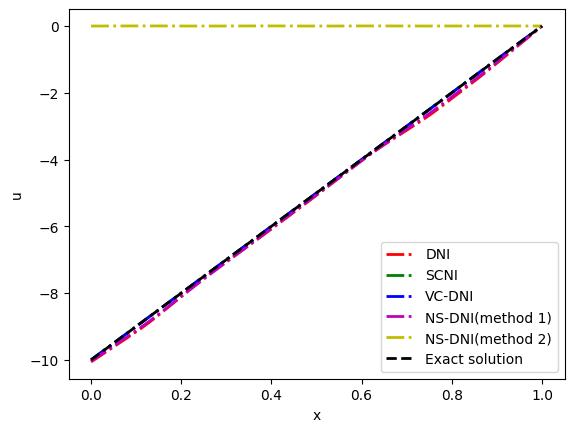

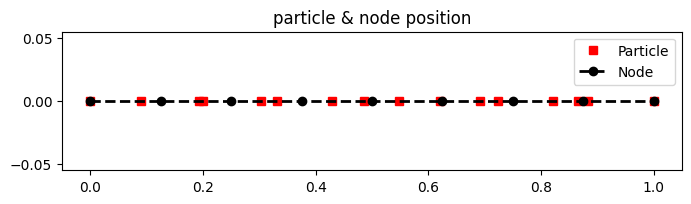

In [8]:
##  eq : u_,xx = 0
##  N_BC : u_,x(0) = 10
##  D_BC : u(1) = 0
##  exact sol = 10x - 10
##  weak form ==> w_,x*u_,x = -10*w

randomParticle = True
particlePerCell = 2
domainheight = 1
simulationTime = 1
dt = 1
betaNorm = 1000
supportNorm = 1.5
dirichletBC = domainheight
tractionBC = 0
# NSNI = True
nodeNum = 9
particleNum, dx, dp, xp, vp, xI, uI, n, timeStepNum = Initialize(particlePerCell, nodeNum, domainheight, dt, simulationTime, randomParticle)
uI_scni = np.copy(uI)
uI_vc = np.copy(uI)
uI_nsni1 = np.copy(uI)
uI_nsni2 = np.copy(uI)

for t in range(timeStepNum):
    K = np.zeros((nodeNum,nodeNum))
    F = np.zeros(nodeNum)
    K_VC = np.copy(K)
    F_VC = np.copy(F)
    K_SC = np.copy(K)
    F_SC = np.copy(F)
    K_NS1 = np.copy(K)
    K_NS2 = np.copy(K)
    F_NS = np.copy(F)
    beta = betaNorm * 1 / dx
    phi, dphi = GetRK(xI, dx, xp, supportNorm)

    phi_vc,dphi_vc = GetRK(xI,dx,xp,supportNorm) # DNI shape function
    ksi, eps = get_vc(phi, dphi, nodeNum, vp, n)
    checkVC = 0

    phi_scni,dphi_scni = scni(xp,particleNum,domainheight,xI,dx,supportNorm)

    ddphi_ns1,M1 = nsni1(xI,dx,xp,supportNorm,nodeNum,particleNum,domainheight)
    ddphi_ns2,M1 = nsni2(xI,dx,xp,supportNorm,nodeNum,particleNum,domainheight)

    for p in range(particleNum):
        K += np.outer(dphi[:,p],dphi[:,p]) * vp[p]
        if xp[p] == dirichletBC:
            Nistche_term = beta * np.outer(phi[:,p],phi[:,p]) - np.outer(dphi[:,p],phi[:,p]) * n[p] * 1 - np.outer(phi[:,p],dphi[:,p]) * n[p] * 1
            K += Nistche_term
        elif xp[p] == tractionBC:
            F -= phi[:,p] * 10

        withinSupport = phi_vc[:, p] > eps # bool
        dphi_vc[:, p] = dphi_vc[:, p] + ksi * withinSupport
        checkVC = checkVC + np.dot(dphi_vc[:, p], vp[p]) - np.dot(phi_vc[:, p], n[p]) * 1
        K_VC += np.outer(dphi_vc[:,p],dphi[:,p]) * vp[p]
        if xp[p] == dirichletBC:
            Nistche_term = beta * np.outer(phi_vc[:,p],phi_vc[:,p]) - np.outer(dphi_vc[:,p],phi_vc[:,p]) * n[p] * 1 - np.outer(phi_vc[:,p],dphi_vc[:,p]) * n[p] * 1
            K_VC += Nistche_term
        elif xp[p] == tractionBC:
            F_VC -= phi_vc[:,p] * 10 * 1

        K_SC += np.outer(dphi_scni[:,p],dphi_scni[:,p]) * vp[p]
        if xp[p] == dirichletBC:
            Nistche_term = beta * np.outer(phi_scni[:,p],phi_scni[:,p]) - np.outer(dphi_scni[:,p],phi_scni[:,p]) * n[p] * 1 - np.outer(phi_scni[:,p],dphi_scni[:,p]) * n[p] * 1
            K_SC += Nistche_term
        elif xp[p] == tractionBC:
            F_SC -= phi_scni[:,p] * 10 * 1

        K_NS1 += np.outer(dphi[:,p],dphi[:,p]) * vp[p]
        K_NS1 += np.outer(ddphi_ns1[:,p],ddphi_ns1[:,p]) * M1[p]
        # K_NS2 += np.outer(dphi[:,p],dphi[:,p]) * vp[p]
        K_NS2 += np.outer(ddphi_ns2[:,p],ddphi_ns2[:,p]) * vp[p] #* M1[p]
        if xp[p] == dirichletBC:
            Nistche_term = beta * np.outer(phi[:,p],phi[:,p]) - np.outer(dphi[:,p],phi[:,p]) * n[p] * 1 - np.outer(phi[:,p],dphi[:,p]) * n[p] * 1
            K_NS1 += Nistche_term
            K_NS2 += Nistche_term
        elif xp[p] == tractionBC:
            F_NS -= phi[:,p] * 10

    uI = np.linalg.solve(K, F)
    uI_vc = np.linalg.solve(K_VC, F_VC)
    uI_scni = np.linalg.solve(K_SC, F_SC)
    uI_nsni1 = np.linalg.solve(K_NS1, F_NS)
    uI_nsni2 = np.linalg.solve(K_NS2, F_NS)

step = 0.01
x = np.arange(0, domainheight + step, step)
f_exact = 10 * x - 10

phiU, _ = GetRK(xI, dx, x, supportNorm)
u = np.dot(uI, phiU)
u_vc = np.dot(uI_vc,phiU)
u_scni = np.dot(uI_scni,phiU)
u_nsni1 = np.dot(uI_nsni1, phiU)
u_nsni2 = np.dot(uI_nsni2, phiU)

error = f_exact - u
L2_error = np.sqrt(np.trapz(error**2,x))
error_vc = f_exact - u_vc
L2_error_vc = np.sqrt(np.trapz(error_vc**2,x))
error_scni = f_exact - u_scni
L2_error_scni = np.sqrt(np.trapz(error_scni**2,x))
error_nsni1 = f_exact - u_nsni1
L2_error_nsni1 = np.sqrt(np.trapz(error_nsni1**2,x))
error_nsni2 = f_exact - u_nsni2
L2_error_nsni2 = np.sqrt(np.trapz(error_nsni2**2,x))
print("DNI : {}".format(L2_error))
print("VC-DNI : {}".format(L2_error_vc))
print("SCNI : {}".format(L2_error_scni))
print("NS-DNI(method 1) : {}".format(L2_error_nsni1))
print("NS-DNI(method 2) : {:.4f}".format(L2_error_nsni2))

plt.figure(1)
plt.plot(x,u,'r-.',lw=2,label='DNI')
plt.plot(x,u_scni,'g-.',lw=2,label='SCNI')
plt.plot(x,u_vc,'b-.',lw=2,label='VC-DNI')
plt.plot(x,u_nsni1,'m-.',lw=2,label='NS-DNI(method 1)')
plt.plot(x,u_nsni2,'y-.',lw=2,label='NS-DNI(method 2)')
plt.plot(x,f_exact,'k--',lw=2,label='Exact solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

plt.figure(2,(8,1.8))
nodeHeight = np.zeros(len(xI))
particleHeight = np.zeros(len(xp))
plt.plot(xp,particleHeight,'rs',lw=1,label='Particle')
plt.plot(xI,nodeHeight,'ko--',lw=2,label='Node')
plt.title('particle & node position')
plt.legend()

plt.show()